In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


1/8 [==>...........................] - ETA: 15s - loss: 0.0111 - STD: 1.0388e-04 - MAE: 0.0888

2/8 [======>.......................] - ETA: 0s - loss: 0.0142 - STD: 1.1533e-04 - MAE: 0.0938 

3/8 [==========>...................] - ETA: 2s - loss: 0.0145 - STD: 1.3115e-04 - MAE: 0.0934

4/8 [==============>...............] - ETA: 1s - loss: 0.0132 - STD: 1.5896e-04 - MAE: 0.0887

5/8 [=================>............] - ETA: 0s - loss: 0.0126 - STD: 2.0469e-04 - MAE: 0.0883

6/8 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.5947e-04 - MAE: 0.0901

7/8 [=========================>....] - ETA: 0s - loss: 0.0124 - STD: 3.0910e-04 - MAE: 0.0893

8/8 [==============================] - ETA: 0s - loss: 0.0119 - STD: 3.4746e-04 - MAE: 0.0874

8/8 [==============================] - 5s 411ms/step - loss: 0.0119 - STD: 3.4746e-04 - MAE: 0.0874 - val_loss: 0.0096 - val_STD: 4.6817e-04 - val_MAE: 0.0732


Epoch 2/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0104 - STD: 6.1358e-04 - MAE: 0.0748

2/8 [======>.......................] - ETA: 1s - loss: 0.0107 - STD: 6.2417e-04 - MAE: 0.0756

3/8 [==========>...................] - ETA: 0s - loss: 0.0107 - STD: 6.4864e-04 - MAE: 0.0758

4/8 [==============>...............] - ETA: 0s - loss: 0.0105 - STD: 6.8688e-04 - MAE: 0.0754

5/8 [=================>............] - ETA: 0s - loss: 0.0102 - STD: 7.3796e-04 - MAE: 0.0751

6/8 [=====================>........] - ETA: 0s - loss: 0.0100 - STD: 7.9647e-04 - MAE: 0.0756

7/8 [=========================>....] - ETA: 0s - loss: 0.0100 - STD: 8.5632e-04 - MAE: 0.0766

8/8 [==============================] - ETA: 0s - loss: 0.0100 - STD: 9.1233e-04 - MAE: 0.0775

8/8 [==============================] - 2s 237ms/step - loss: 0.0100 - STD: 9.1233e-04 - MAE: 0.0775 - val_loss: 0.0091 - val_STD: 9.9522e-04 - val_MAE: 0.0627


Epoch 3/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0096 - STD: 0.0013 - MAE: 0.0807

2/8 [======>.......................] - ETA: 1s - loss: 0.0094 - STD: 0.0013 - MAE: 0.0785

3/8 [==========>...................] - ETA: 1s - loss: 0.0093 - STD: 0.0013 - MAE: 0.0770

4/8 [==============>...............] - ETA: 0s - loss: 0.0094 - STD: 0.0013 - MAE: 0.0761

5/8 [=================>............] - ETA: 0s - loss: 0.0094 - STD: 0.0013 - MAE: 0.0756

6/8 [=====================>........] - ETA: 0s - loss: 0.0094 - STD: 0.0014 - MAE: 0.0752

7/8 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 0.0014 - MAE: 0.0750

8/8 [==============================] - ETA: 0s - loss: 0.0094 - STD: 0.0014 - MAE: 0.0749

8/8 [==============================] - 2s 242ms/step - loss: 0.0094 - STD: 0.0014 - MAE: 0.0749 - val_loss: 0.0085 - val_STD: 0.0014 - val_MAE: 0.0621


Epoch 4/10000


1/8 [==>...........................] - ETA: 0s - loss: 0.0092 - STD: 0.0019 - MAE: 0.0762

2/8 [======>.......................] - ETA: 1s - loss: 0.0093 - STD: 0.0020 - MAE: 0.0772

3/8 [==========>...................] - ETA: 1s - loss: 0.0093 - STD: 0.0021 - MAE: 0.0777

4/8 [==============>...............] - ETA: 0s - loss: 0.0093 - STD: 0.0021 - MAE: 0.0777

5/8 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 0.0022 - MAE: 0.0774

6/8 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.0022 - MAE: 0.0768

7/8 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 0.0023 - MAE: 0.0764

8/8 [==============================] - ETA: 0s - loss: 0.0092 - STD: 0.0023 - MAE: 0.0760

8/8 [==============================] - 2s 274ms/step - loss: 0.0092 - STD: 0.0023 - MAE: 0.0760 - val_loss: 0.0085 - val_STD: 0.0021 - val_MAE: 0.0646


Epoch 5/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0092 - STD: 0.0028 - MAE: 0.0733

2/8 [======>.......................] - ETA: 1s - loss: 0.0092 - STD: 0.0029 - MAE: 0.0735

3/8 [==========>...................] - ETA: 0s - loss: 0.0091 - STD: 0.0030 - MAE: 0.0736

4/8 [==============>...............] - ETA: 0s - loss: 0.0091 - STD: 0.0032 - MAE: 0.0739

5/8 [=================>............] - ETA: 0s - loss: 0.0090 - STD: 0.0033 - MAE: 0.0742

6/8 [=====================>........] - ETA: 0s - loss: 0.0090 - STD: 0.0035 - MAE: 0.0746

7/8 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0036 - MAE: 0.0747

8/8 [==============================] - ETA: 0s - loss: 0.0090 - STD: 0.0038 - MAE: 0.0747

8/8 [==============================] - 2s 241ms/step - loss: 0.0090 - STD: 0.0038 - MAE: 0.0747 - val_loss: 0.0082 - val_STD: 0.0038 - val_MAE: 0.0618


Epoch 6/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0088 - STD: 0.0051 - MAE: 0.0735

2/8 [======>.......................] - ETA: 1s - loss: 0.0088 - STD: 0.0052 - MAE: 0.0732

3/8 [==========>...................] - ETA: 1s - loss: 0.0088 - STD: 0.0054 - MAE: 0.0730

4/8 [==============>...............] - ETA: 0s - loss: 0.0088 - STD: 0.0056 - MAE: 0.0729

5/8 [=================>............] - ETA: 0s - loss: 0.0088 - STD: 0.0059 - MAE: 0.0728

6/8 [=====================>........] - ETA: 0s - loss: 0.0087 - STD: 0.0062 - MAE: 0.0730

7/8 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.0065 - MAE: 0.0731

8/8 [==============================] - ETA: 0s - loss: 0.0087 - STD: 0.0068 - MAE: 0.0732

8/8 [==============================] - 2s 240ms/step - loss: 0.0087 - STD: 0.0068 - MAE: 0.0732 - val_loss: 0.0079 - val_STD: 0.0075 - val_MAE: 0.0597


Epoch 7/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0085 - STD: 0.0100 - MAE: 0.0736

2/8 [======>.......................] - ETA: 1s - loss: 0.0084 - STD: 0.0104 - MAE: 0.0729

3/8 [==========>...................] - ETA: 1s - loss: 0.0084 - STD: 0.0108 - MAE: 0.0726

4/8 [==============>...............] - ETA: 0s - loss: 0.0084 - STD: 0.0113 - MAE: 0.0722

5/8 [=================>............] - ETA: 0s - loss: 0.0083 - STD: 0.0118 - MAE: 0.0720

6/8 [=====================>........] - ETA: 0s - loss: 0.0083 - STD: 0.0124 - MAE: 0.0718

7/8 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0131 - MAE: 0.0717

8/8 [==============================] - ETA: 0s - loss: 0.0082 - STD: 0.0138 - MAE: 0.0716

8/8 [==============================] - 2s 240ms/step - loss: 0.0082 - STD: 0.0138 - MAE: 0.0716 - val_loss: 0.0072 - val_STD: 0.0154 - val_MAE: 0.0569


Epoch 8/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0078 - STD: 0.0206 - MAE: 0.0705

2/8 [======>.......................] - ETA: 1s - loss: 0.0077 - STD: 0.0215 - MAE: 0.0702

3/8 [==========>...................] - ETA: 1s - loss: 0.0077 - STD: 0.0224 - MAE: 0.0698

4/8 [==============>...............] - ETA: 0s - loss: 0.0077 - STD: 0.0233 - MAE: 0.0695

6/8 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0255 - MAE: 0.0690

7/8 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.0266 - MAE: 0.0688

8/8 [==============================] - ETA: 0s - loss: 0.0075 - STD: 0.0278 - MAE: 0.0687

8/8 [==============================] - 2s 240ms/step - loss: 0.0075 - STD: 0.0278 - MAE: 0.0687 - val_loss: 0.0065 - val_STD: 0.0286 - val_MAE: 0.0531


Epoch 9/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0072 - STD: 0.0382 - MAE: 0.0672

2/8 [======>.......................] - ETA: 1s - loss: 0.0072 - STD: 0.0391 - MAE: 0.0668

3/8 [==========>...................] - ETA: 0s - loss: 0.0072 - STD: 0.0401 - MAE: 0.0666

4/8 [==============>...............] - ETA: 0s - loss: 0.0072 - STD: 0.0410 - MAE: 0.0664

5/8 [=================>............] - ETA: 0s - loss: 0.0071 - STD: 0.0420 - MAE: 0.0663

6/8 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0428 - MAE: 0.0662

7/8 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0435 - MAE: 0.0661

8/8 [==============================] - ETA: 0s - loss: 0.0071 - STD: 0.0441 - MAE: 0.0659

8/8 [==============================] - 2s 239ms/step - loss: 0.0071 - STD: 0.0441 - MAE: 0.0659 - val_loss: 0.0061 - val_STD: 0.0350 - val_MAE: 0.0504


Epoch 10/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0069 - STD: 0.0486 - MAE: 0.0646

2/8 [======>.......................] - ETA: 1s - loss: 0.0069 - STD: 0.0487 - MAE: 0.0647

3/8 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0487 - MAE: 0.0645

4/8 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.0484 - MAE: 0.0643

5/8 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0482 - MAE: 0.0642

6/8 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0480 - MAE: 0.0641

7/8 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0478 - MAE: 0.0640

8/8 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0476 - MAE: 0.0639

8/8 [==============================] - 2s 237ms/step - loss: 0.0067 - STD: 0.0476 - MAE: 0.0639 - val_loss: 0.0057 - val_STD: 0.0305 - val_MAE: 0.0497


Epoch 11/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0066 - STD: 0.0456 - MAE: 0.0630

2/8 [======>.......................] - ETA: 1s - loss: 0.0065 - STD: 0.0456 - MAE: 0.0628

3/8 [==========>...................] - ETA: 1s - loss: 0.0065 - STD: 0.0458 - MAE: 0.0627

4/8 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0459 - MAE: 0.0626

5/8 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0461 - MAE: 0.0625

6/8 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0464 - MAE: 0.0623

7/8 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0468 - MAE: 0.0623

8/8 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0472 - MAE: 0.0622

8/8 [==============================] - 2s 240ms/step - loss: 0.0064 - STD: 0.0472 - MAE: 0.0622 - val_loss: 0.0054 - val_STD: 0.0343 - val_MAE: 0.0491


Epoch 12/10000


1/8 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0510 - MAE: 0.0609

2/8 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0517 - MAE: 0.0611

3/8 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0523 - MAE: 0.0612

4/8 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0527 - MAE: 0.0611

5/8 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0531 - MAE: 0.0609

6/8 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0535 - MAE: 0.0609

7/8 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0539 - MAE: 0.0609

8/8 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0541 - MAE: 0.0607

8/8 [==============================] - 2s 269ms/step - loss: 0.0062 - STD: 0.0541 - MAE: 0.0607 - val_loss: 0.0051 - val_STD: 0.0388 - val_MAE: 0.0492


Epoch 13/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0569 - MAE: 0.0604

2/8 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0603

3/8 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0599

4/8 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0599

5/8 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0564 - MAE: 0.0598

6/8 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0596

7/8 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0595

8/8 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0560 - MAE: 0.0594

8/8 [==============================] - 2s 240ms/step - loss: 0.0059 - STD: 0.0560 - MAE: 0.0594 - val_loss: 0.0048 - val_STD: 0.0373 - val_MAE: 0.0471


Epoch 14/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0546 - MAE: 0.0585

2/8 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0550 - MAE: 0.0585

3/8 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0551 - MAE: 0.0584

4/8 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0550 - MAE: 0.0582

5/8 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0551 - MAE: 0.0581

6/8 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0552 - MAE: 0.0580

7/8 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0553 - MAE: 0.0579

8/8 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0555 - MAE: 0.0579

8/8 [==============================] - 2s 240ms/step - loss: 0.0056 - STD: 0.0555 - MAE: 0.0579 - val_loss: 0.0046 - val_STD: 0.0381 - val_MAE: 0.0462


Epoch 15/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0550 - MAE: 0.0562

2/8 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0570 - MAE: 0.0574

3/8 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0558 - MAE: 0.0569

4/8 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0573 - MAE: 0.0578

5/8 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0563 - MAE: 0.0575

6/8 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0569 - MAE: 0.0574

7/8 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0574 - MAE: 0.0574

8/8 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0570 - MAE: 0.0572

8/8 [==============================] - 2s 237ms/step - loss: 0.0056 - STD: 0.0570 - MAE: 0.0572 - val_loss: 0.0047 - val_STD: 0.0429 - val_MAE: 0.0483


Epoch 16/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0580

3/8 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0592 - MAE: 0.0563

4/8 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0602 - MAE: 0.0567

5/8 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0597 - MAE: 0.0564

6/8 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0598 - MAE: 0.0562

7/8 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0603 - MAE: 0.0563

8/8 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0599 - MAE: 0.0561

8/8 [==============================] - 2s 241ms/step - loss: 0.0054 - STD: 0.0599 - MAE: 0.0561 - val_loss: 0.0045 - val_STD: 0.0445 - val_MAE: 0.0473


Epoch 17/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0568

2/8 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0558

3/8 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0616 - MAE: 0.0553

4/8 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0557

5/8 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0555

6/8 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0622 - MAE: 0.0555

8/8 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0621 - MAE: 0.0554

8/8 [==============================] - 2s 238ms/step - loss: 0.0052 - STD: 0.0621 - MAE: 0.0554 - val_loss: 0.0045 - val_STD: 0.0460 - val_MAE: 0.0475


Epoch 18/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0567

2/8 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0555

3/8 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0553

4/8 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0636 - MAE: 0.0553

5/8 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0550

6/8 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0551

7/8 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0550

8/8 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0549

8/8 [==============================] - 2s 239ms/step - loss: 0.0052 - STD: 0.0631 - MAE: 0.0549 - val_loss: 0.0043 - val_STD: 0.0454 - val_MAE: 0.0464


Epoch 19/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0648 - MAE: 0.0554

2/8 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0631 - MAE: 0.0546

3/8 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0547

4/8 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0546

5/8 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0545

6/8 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0545

7/8 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0544

8/8 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0546

8/8 [==============================] - 2s 240ms/step - loss: 0.0051 - STD: 0.0635 - MAE: 0.0546 - val_loss: 0.0043 - val_STD: 0.0425 - val_MAE: 0.0458


Epoch 20/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0538

2/8 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0630 - MAE: 0.0544

3/8 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0628 - MAE: 0.0542

4/8 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0543

5/8 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0631 - MAE: 0.0542

6/8 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0633 - MAE: 0.0542

7/8 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0542

8/8 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0633 - MAE: 0.0542

8/8 [==============================] - 2s 239ms/step - loss: 0.0050 - STD: 0.0633 - MAE: 0.0542 - val_loss: 0.0042 - val_STD: 0.0451 - val_MAE: 0.0454


Epoch 21/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0644 - MAE: 0.0542

2/8 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0538

3/8 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0642 - MAE: 0.0542

5/8 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0643 - MAE: 0.0546

6/8 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0545

7/8 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0547

8/8 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0545

8/8 [==============================] - 2s 238ms/step - loss: 0.0051 - STD: 0.0635 - MAE: 0.0545 - val_loss: 0.0041 - val_STD: 0.0452 - val_MAE: 0.0454


Epoch 22/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0647 - MAE: 0.0543

2/8 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0646 - MAE: 0.0542

3/8 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0634 - MAE: 0.0539

4/8 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0642 - MAE: 0.0543

5/8 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0633 - MAE: 0.0540

6/8 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0637 - MAE: 0.0541

7/8 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0636 - MAE: 0.0541

8/8 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0634 - MAE: 0.0540

8/8 [==============================] - 2s 237ms/step - loss: 0.0050 - STD: 0.0634 - MAE: 0.0540 - val_loss: 0.0043 - val_STD: 0.0468 - val_MAE: 0.0466


Epoch 23/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0668 - MAE: 0.0552

2/8 [======>.......................] - ETA: 0s - loss: 0.0050 - STD: 0.0633 - MAE: 0.0542

3/8 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0645 - MAE: 0.0547

4/8 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0639 - MAE: 0.0543

5/8 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0638 - MAE: 0.0541

6/8 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0642 - MAE: 0.0542

7/8 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0637 - MAE: 0.0540

8/8 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0641 - MAE: 0.0541

8/8 [==============================] - 2s 239ms/step - loss: 0.0050 - STD: 0.0641 - MAE: 0.0541 - val_loss: 0.0041 - val_STD: 0.0439 - val_MAE: 0.0448


Epoch 24/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0530

2/8 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0633 - MAE: 0.0532

3/8 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0641 - MAE: 0.0534

4/8 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0636 - MAE: 0.0533

5/8 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0643 - MAE: 0.0536

6/8 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0639 - MAE: 0.0534

7/8 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0643 - MAE: 0.0535

8/8 [==============================] - 2s 239ms/step - loss: 0.0049 - STD: 0.0642 - MAE: 0.0534 - val_loss: 0.0041 - val_STD: 0.0457 - val_MAE: 0.0450


Epoch 25/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0652 - MAE: 0.0533

2/8 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0531

3/8 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0530

4/8 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0531

5/8 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0530

6/8 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0652 - MAE: 0.0532

7/8 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0531

8/8 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0653 - MAE: 0.0533

8/8 [==============================] - 2s 237ms/step - loss: 0.0048 - STD: 0.0653 - MAE: 0.0533 - val_loss: 0.0042 - val_STD: 0.0432 - val_MAE: 0.0453


Epoch 26/10000


1/8 [==>...........................] - ETA: 0s - loss: 0.0049 - STD: 0.0615 - MAE: 0.0525

2/8 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0656 - MAE: 0.0541

3/8 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0538

4/8 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0652 - MAE: 0.0546

5/8 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0638 - MAE: 0.0543

6/8 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0645 - MAE: 0.0544

7/8 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0644 - MAE: 0.0541

8/8 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0642 - MAE: 0.0539

8/8 [==============================] - 2s 268ms/step - loss: 0.0050 - STD: 0.0642 - MAE: 0.0539 - val_loss: 0.0042 - val_STD: 0.0476 - val_MAE: 0.0469


Epoch 27/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0551

2/8 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0634 - MAE: 0.0540

3/8 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0647 - MAE: 0.0543

4/8 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0644 - MAE: 0.0539

5/8 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0640 - MAE: 0.0537

6/8 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0645 - MAE: 0.0538

7/8 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0639 - MAE: 0.0536

8/8 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0642 - MAE: 0.0536

8/8 [==============================] - 2s 242ms/step - loss: 0.0049 - STD: 0.0642 - MAE: 0.0536 - val_loss: 0.0040 - val_STD: 0.0456 - val_MAE: 0.0449


Epoch 28/10000


1/8 [==>...........................] - ETA: 0s - loss: 0.0049 - STD: 0.0650 - MAE: 0.0534

2/8 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0527

3/8 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0532

4/8 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0530

5/8 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0530

6/8 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0648 - MAE: 0.0530

7/8 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0647 - MAE: 0.0529

8/8 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0530

8/8 [==============================] - 2s 267ms/step - loss: 0.0048 - STD: 0.0650 - MAE: 0.0530 - val_loss: 0.0041 - val_STD: 0.0444 - val_MAE: 0.0446


Epoch 29/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0632 - MAE: 0.0522

2/8 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0526

3/8 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0653 - MAE: 0.0526

4/8 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0652 - MAE: 0.0526

5/8 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0656 - MAE: 0.0527

6/8 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0654 - MAE: 0.0526

7/8 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0657 - MAE: 0.0527

8/8 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0656 - MAE: 0.0526

8/8 [==============================] - 2s 239ms/step - loss: 0.0048 - STD: 0.0656 - MAE: 0.0526 - val_loss: 0.0040 - val_STD: 0.0474 - val_MAE: 0.0453


Epoch 30/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0674 - MAE: 0.0532

2/8 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0661 - MAE: 0.0526

3/8 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0527

4/8 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0524

5/8 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0665 - MAE: 0.0526

6/8 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0660 - MAE: 0.0525

7/8 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0665 - MAE: 0.0527

8/8 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0660 - MAE: 0.0526

8/8 [==============================] - 2s 237ms/step - loss: 0.0048 - STD: 0.0660 - MAE: 0.0526 - val_loss: 0.0041 - val_STD: 0.0487 - val_MAE: 0.0464


Epoch 31/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0539

2/8 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0658 - MAE: 0.0529

3/8 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0535

4/8 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0654 - MAE: 0.0532

5/8 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0664 - MAE: 0.0537

6/8 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0653 - MAE: 0.0535

7/8 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0658 - MAE: 0.0537

8/8 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0655 - MAE: 0.0534

8/8 [==============================] - 2s 243ms/step - loss: 0.0049 - STD: 0.0655 - MAE: 0.0534 - val_loss: 0.0040 - val_STD: 0.0454 - val_MAE: 0.0448


Epoch 32/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0522

3/8 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0525

4/8 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0651 - MAE: 0.0529

5/8 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0527

6/8 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0527

7/8 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0527

8/8 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0647 - MAE: 0.0526

8/8 [==============================] - 2s 237ms/step - loss: 0.0047 - STD: 0.0647 - MAE: 0.0526 - val_loss: 0.0041 - val_STD: 0.0483 - val_MAE: 0.0466


Epoch 33/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0539

2/8 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0655 - MAE: 0.0528

3/8 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0662 - MAE: 0.0528

4/8 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0526

5/8 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0525

6/8 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0526

7/8 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0524

8/8 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0525

8/8 [==============================] - 2s 238ms/step - loss: 0.0047 - STD: 0.0663 - MAE: 0.0525 - val_loss: 0.0041 - val_STD: 0.0450 - val_MAE: 0.0446


Epoch 34/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0638 - MAE: 0.0516

2/8 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0665 - MAE: 0.0524

3/8 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0521

4/8 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0664 - MAE: 0.0523

5/8 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0661 - MAE: 0.0523

6/8 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0664 - MAE: 0.0523

7/8 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0523

8/8 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0664 - MAE: 0.0522

8/8 [==============================] - 2s 240ms/step - loss: 0.0047 - STD: 0.0664 - MAE: 0.0522 - val_loss: 0.0039 - val_STD: 0.0474 - val_MAE: 0.0452


Epoch 35/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0521

2/8 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0662 - MAE: 0.0519

3/8 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0522

4/8 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0520

5/8 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0527

6/8 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0656 - MAE: 0.0529

7/8 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0667 - MAE: 0.0536

8/8 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0656 - MAE: 0.0535

8/8 [==============================] - 2s 235ms/step - loss: 0.0049 - STD: 0.0656 - MAE: 0.0535 - val_loss: 0.0040 - val_STD: 0.0482 - val_MAE: 0.0467


Epoch 36/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0537

2/8 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0532

3/8 [==========>...................] - ETA: 1s - loss: 0.0048 - STD: 0.0648 - MAE: 0.0527

4/8 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0659 - MAE: 0.0533

5/8 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0530

6/8 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0529

7/8 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0652 - MAE: 0.0529

8/8 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0646 - MAE: 0.0528

8/8 [==============================] - 2s 236ms/step - loss: 0.0048 - STD: 0.0646 - MAE: 0.0528 - val_loss: 0.0041 - val_STD: 0.0479 - val_MAE: 0.0472


Epoch 37/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0539

2/8 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0526

3/8 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0524

4/8 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0528

5/8 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0648 - MAE: 0.0526

6/8 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0528

7/8 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0526

8/8 [==============================] - 2s 236ms/step - loss: 0.0047 - STD: 0.0653 - MAE: 0.0525 - val_loss: 0.0040 - val_STD: 0.0490 - val_MAE: 0.0471


Epoch 38/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0535

2/8 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0525

3/8 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0668 - MAE: 0.0525

4/8 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0669 - MAE: 0.0524

5/8 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0664 - MAE: 0.0522

6/8 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0524

7/8 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0522

8/8 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0668 - MAE: 0.0522

8/8 [==============================] - 2s 239ms/step - loss: 0.0047 - STD: 0.0668 - MAE: 0.0522 - val_loss: 0.0039 - val_STD: 0.0471 - val_MAE: 0.0449


Epoch 39/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0518

2/8 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0517

3/8 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0517

4/8 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0517

5/8 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0516

6/8 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0516

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0516

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0517

8/8 [==============================] - 2s 236ms/step - loss: 0.0046 - STD: 0.0671 - MAE: 0.0517 - val_loss: 0.0040 - val_STD: 0.0459 - val_MAE: 0.0447


Epoch 40/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0513

2/8 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0673 - MAE: 0.0521

3/8 [==========>...................] - ETA: 1s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0518

4/8 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0520

5/8 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0519

6/8 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0519

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0518

8/8 [==============================] - 2s 237ms/step - loss: 0.0046 - STD: 0.0670 - MAE: 0.0518 - val_loss: 0.0039 - val_STD: 0.0478 - val_MAE: 0.0453


Epoch 41/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0676 - MAE: 0.0518

2/8 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0515

3/8 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0516

4/8 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0515

5/8 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0515

6/8 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0673 - MAE: 0.0515

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0515

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0675 - MAE: 0.0516

8/8 [==============================] - 2s 238ms/step - loss: 0.0046 - STD: 0.0675 - MAE: 0.0516 - val_loss: 0.0042 - val_STD: 0.0446 - val_MAE: 0.0451


Epoch 42/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0513

2/8 [======>.......................] - ETA: 1s - loss: 0.0048 - STD: 0.0679 - MAE: 0.0531

3/8 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0649 - MAE: 0.0531

4/8 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0539

5/8 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0656 - MAE: 0.0535

6/8 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0662 - MAE: 0.0535

7/8 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0661 - MAE: 0.0532

8/8 [==============================] - 2s 234ms/step - loss: 0.0049 - STD: 0.0658 - MAE: 0.0530 - val_loss: 0.0040 - val_STD: 0.0486 - val_MAE: 0.0474


Epoch 43/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0535

2/8 [======>.......................] - ETA: 0s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0524

3/8 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0526

4/8 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0523

5/8 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0522

6/8 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0522

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0520

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0521

8/8 [==============================] - 2s 238ms/step - loss: 0.0046 - STD: 0.0658 - MAE: 0.0521 - val_loss: 0.0040 - val_STD: 0.0459 - val_MAE: 0.0447


Epoch 44/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0513

2/8 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0514

3/8 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0515

4/8 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

5/8 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0516

6/8 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0515

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0516

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0515

8/8 [==============================] - 2s 238ms/step - loss: 0.0046 - STD: 0.0669 - MAE: 0.0515 - val_loss: 0.0039 - val_STD: 0.0483 - val_MAE: 0.0455


Epoch 45/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0684 - MAE: 0.0516

2/8 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0516

3/8 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0676 - MAE: 0.0514

4/8 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0684 - MAE: 0.0518

5/8 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0517

6/8 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0679 - MAE: 0.0520

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0674 - MAE: 0.0518

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0677 - MAE: 0.0519

8/8 [==============================] - 2s 237ms/step - loss: 0.0046 - STD: 0.0677 - MAE: 0.0519 - val_loss: 0.0039 - val_STD: 0.0464 - val_MAE: 0.0448


Epoch 46/10000


1/8 [==>...........................] - ETA: 0s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0510

2/8 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0511

3/8 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0513

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0512

5/8 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0515

6/8 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0514

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0516

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0516

8/8 [==============================] - 2s 269ms/step - loss: 0.0046 - STD: 0.0667 - MAE: 0.0516 - val_loss: 0.0039 - val_STD: 0.0497 - val_MAE: 0.0473


Epoch 47/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0527

2/8 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0517

3/8 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0679 - MAE: 0.0520

5/8 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0673 - MAE: 0.0517

6/8 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0673 - MAE: 0.0516

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0515

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0673 - MAE: 0.0515

8/8 [==============================] - 2s 237ms/step - loss: 0.0046 - STD: 0.0673 - MAE: 0.0515 - val_loss: 0.0039 - val_STD: 0.0468 - val_MAE: 0.0449


Epoch 48/10000


1/8 [==>...........................] - ETA: 0s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0509

2/8 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0512

3/8 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0511

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0514

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0513

8/8 [==============================] - 2s 268ms/step - loss: 0.0046 - STD: 0.0672 - MAE: 0.0513 - val_loss: 0.0041 - val_STD: 0.0523 - val_MAE: 0.0507


Epoch 49/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0738 - MAE: 0.0552

2/8 [======>.......................] - ETA: 0s - loss: 0.0050 - STD: 0.0663 - MAE: 0.0542

3/8 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0549

4/8 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0542

5/8 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0671 - MAE: 0.0539

6/8 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0536

7/8 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0664 - MAE: 0.0532

8/8 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0668 - MAE: 0.0533

8/8 [==============================] - 2s 237ms/step - loss: 0.0048 - STD: 0.0668 - MAE: 0.0533 - val_loss: 0.0043 - val_STD: 0.0425 - val_MAE: 0.0455


Epoch 50/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0048 - STD: 0.0601 - MAE: 0.0511

2/8 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0517

3/8 [==========>...................] - ETA: 1s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0518

4/8 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0641 - MAE: 0.0516

5/8 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0518

6/8 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0648 - MAE: 0.0517

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0517

8/8 [==============================] - 2s 235ms/step - loss: 0.0046 - STD: 0.0653 - MAE: 0.0517 - val_loss: 0.0040 - val_STD: 0.0452 - val_MAE: 0.0446


Epoch 51/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0640 - MAE: 0.0510

2/8 [======>.......................] - ETA: 1s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0519

3/8 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0517

4/8 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0519

5/8 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0517

6/8 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0667 - MAE: 0.0515

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0673 - MAE: 0.0516

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0515

8/8 [==============================] - 2s 239ms/step - loss: 0.0046 - STD: 0.0669 - MAE: 0.0515 - val_loss: 0.0039 - val_STD: 0.0497 - val_MAE: 0.0469


Epoch 52/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0521

2/8 [======>.......................] - ETA: 0s - loss: 0.0046 - STD: 0.0682 - MAE: 0.0515

3/8 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0514

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0513

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0512

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0511

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0511

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0511

8/8 [==============================] - 2s 234ms/step - loss: 0.0045 - STD: 0.0682 - MAE: 0.0511 - val_loss: 0.0039 - val_STD: 0.0476 - val_MAE: 0.0451


Epoch 53/10000


1/8 [==>...........................] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0506

2/8 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0510

3/8 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0508

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0509

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0508

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0509

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0509

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0509

8/8 [==============================] - 2s 274ms/step - loss: 0.0045 - STD: 0.0682 - MAE: 0.0509 - val_loss: 0.0038 - val_STD: 0.0492 - val_MAE: 0.0459


Epoch 54/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0512

2/8 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0509

3/8 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0688 - MAE: 0.0512

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0511

5/8 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0686 - MAE: 0.0515

6/8 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0674 - MAE: 0.0516

7/8 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0684 - MAE: 0.0522

8/8 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0672 - MAE: 0.0523

8/8 [==============================] - 2s 237ms/step - loss: 0.0048 - STD: 0.0672 - MAE: 0.0523 - val_loss: 0.0040 - val_STD: 0.0509 - val_MAE: 0.0495


Epoch 55/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0539

2/8 [======>.......................] - ETA: 0s - loss: 0.0047 - STD: 0.0684 - MAE: 0.0521

3/8 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0516

4/8 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0679 - MAE: 0.0520

5/8 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0519

6/8 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0668 - MAE: 0.0522

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0520

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0518

8/8 [==============================] - 2s 237ms/step - loss: 0.0046 - STD: 0.0662 - MAE: 0.0518 - val_loss: 0.0039 - val_STD: 0.0493 - val_MAE: 0.0479


Epoch 56/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0694 - MAE: 0.0531

2/8 [======>.......................] - ETA: 0s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

3/8 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0666 - MAE: 0.0519

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0517

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0514

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0516

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0515

8/8 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0515

8/8 [==============================] - 2s 236ms/step - loss: 0.0046 - STD: 0.0669 - MAE: 0.0515 - val_loss: 0.0038 - val_STD: 0.0480 - val_MAE: 0.0453


Epoch 57/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0510

2/8 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0507

3/8 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0510

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0511

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0510

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0510

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0509

8/8 [==============================] - 2s 237ms/step - loss: 0.0045 - STD: 0.0678 - MAE: 0.0509 - val_loss: 0.0038 - val_STD: 0.0493 - val_MAE: 0.0463


Epoch 58/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0696 - MAE: 0.0511

2/8 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0508

3/8 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0508

4/8 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0508

5/8 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0507

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0508

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0508

8/8 [==============================] - 2s 237ms/step - loss: 0.0045 - STD: 0.0685 - MAE: 0.0510 - val_loss: 0.0040 - val_STD: 0.0464 - val_MAE: 0.0448


Epoch 59/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0503

2/8 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0510

3/8 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0508

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0508

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0507

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0507

8/8 [==============================] - 2s 239ms/step - loss: 0.0045 - STD: 0.0681 - MAE: 0.0507 - val_loss: 0.0038 - val_STD: 0.0492 - val_MAE: 0.0460


Epoch 60/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0510

2/8 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0506

3/8 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0509

4/8 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0506

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0508

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0507

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0510

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0510

8/8 [==============================] - 2s 236ms/step - loss: 0.0045 - STD: 0.0678 - MAE: 0.0510 - val_loss: 0.0042 - val_STD: 0.0532 - val_MAE: 0.0520


Epoch 61/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0750 - MAE: 0.0554

2/8 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0541

3/8 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0690 - MAE: 0.0542

4/8 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0532

5/8 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0675 - MAE: 0.0527

6/8 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0527

7/8 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0668 - MAE: 0.0525

8/8 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0673 - MAE: 0.0527

8/8 [==============================] - 2s 236ms/step - loss: 0.0048 - STD: 0.0673 - MAE: 0.0527 - val_loss: 0.0040 - val_STD: 0.0451 - val_MAE: 0.0448


Epoch 62/10000


1/8 [==>...........................] - ETA: 0s - loss: 0.0045 - STD: 0.0633 - MAE: 0.0502

2/8 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0649 - MAE: 0.0505

3/8 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0510

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0509

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0512

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0659 - MAE: 0.0511

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0510

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0511

8/8 [==============================] - 2s 269ms/step - loss: 0.0045 - STD: 0.0665 - MAE: 0.0511 - val_loss: 0.0041 - val_STD: 0.0450 - val_MAE: 0.0448


Epoch 63/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0046 - STD: 0.0633 - MAE: 0.0504

2/8 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0511

3/8 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0508

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0507

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0511

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0510

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0511

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

8/8 [==============================] - 2s 234ms/step - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510 - val_loss: 0.0038 - val_STD: 0.0475 - val_MAE: 0.0450


Epoch 64/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0503

2/8 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0513

3/8 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0511

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0514

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0512

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0510

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0510

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0509

8/8 [==============================] - 2s 237ms/step - loss: 0.0045 - STD: 0.0679 - MAE: 0.0509 - val_loss: 0.0038 - val_STD: 0.0504 - val_MAE: 0.0474


Epoch 65/10000


1/8 [==>...........................] - ETA: 0s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0519

2/8 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0510

3/8 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0689 - MAE: 0.0512

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0509

5/8 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0507

6/8 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0508

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0507

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0508

8/8 [==============================] - 2s 270ms/step - loss: 0.0045 - STD: 0.0685 - MAE: 0.0508 - val_loss: 0.0039 - val_STD: 0.0470 - val_MAE: 0.0449


Epoch 66/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0501

2/8 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0506

3/8 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

4/8 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0506

5/8 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0505

6/8 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0505

7/8 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0505

8/8 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0504

8/8 [==============================] - 2s 240ms/step - loss: 0.0044 - STD: 0.0683 - MAE: 0.0504 - val_loss: 0.0038 - val_STD: 0.0495 - val_MAE: 0.0460


Epoch 67/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0694 - MAE: 0.0507

2/8 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0503

3/8 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0693 - MAE: 0.0505

4/8 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0504

5/8 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0693 - MAE: 0.0507

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0507

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0692 - MAE: 0.0512

8/8 [==============================] - 2s 236ms/step - loss: 0.0046 - STD: 0.0682 - MAE: 0.0512 - val_loss: 0.0039 - val_STD: 0.0519 - val_MAE: 0.0491


Epoch 68/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0730 - MAE: 0.0531

2/8 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0696 - MAE: 0.0516

3/8 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0687 - MAE: 0.0512

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0692 - MAE: 0.0512

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0510

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0514

7/8 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0676 - MAE: 0.0512

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0513

8/8 [==============================] - 2s 235ms/step - loss: 0.0045 - STD: 0.0679 - MAE: 0.0513 - val_loss: 0.0038 - val_STD: 0.0478 - val_MAE: 0.0454


Epoch 69/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0504

2/8 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0661 - MAE: 0.0502

3/8 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0509

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0507

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0511

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0508

8/8 [==============================] - 2s 237ms/step - loss: 0.0045 - STD: 0.0676 - MAE: 0.0508 - val_loss: 0.0040 - val_STD: 0.0463 - val_MAE: 0.0448


Epoch 70/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0649 - MAE: 0.0500

2/8 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0512

3/8 [==========>...................] - ETA: 1s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0508

4/8 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0510

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0508

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0508

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0506

8/8 [==============================] - 2s 238ms/step - loss: 0.0045 - STD: 0.0678 - MAE: 0.0506 - val_loss: 0.0038 - val_STD: 0.0507 - val_MAE: 0.0474


Epoch 71/10000


1/8 [==>...........................] - ETA: 0s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0515

2/8 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0507

3/8 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0506

4/8 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0505

5/8 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0505

6/8 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0505

7/8 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0504

8/8 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0505

8/8 [==============================] - 2s 268ms/step - loss: 0.0044 - STD: 0.0691 - MAE: 0.0505 - val_loss: 0.0039 - val_STD: 0.0477 - val_MAE: 0.0449


Epoch 72/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0499

2/8 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0507

3/8 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0504

4/8 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0507

5/8 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0505

6/8 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0688 - MAE: 0.0507

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0506

8/8 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0506

8/8 [==============================] - 2s 236ms/step - loss: 0.0044 - STD: 0.0685 - MAE: 0.0506 - val_loss: 0.0038 - val_STD: 0.0488 - val_MAE: 0.0456


Epoch 73/10000


1/8 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

2/8 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0501

3/8 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0504

4/8 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0502

5/8 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0507

6/8 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0505

7/8 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0688 - MAE: 0.0508

8/8 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0507

8/8 [==============================] - 2s 236ms/step - loss: 0.0045 - STD: 0.0681 - MAE: 0.0507 - val_loss: 0.0038 - val_STD: 0.0517 - val_MAE: 0.0487


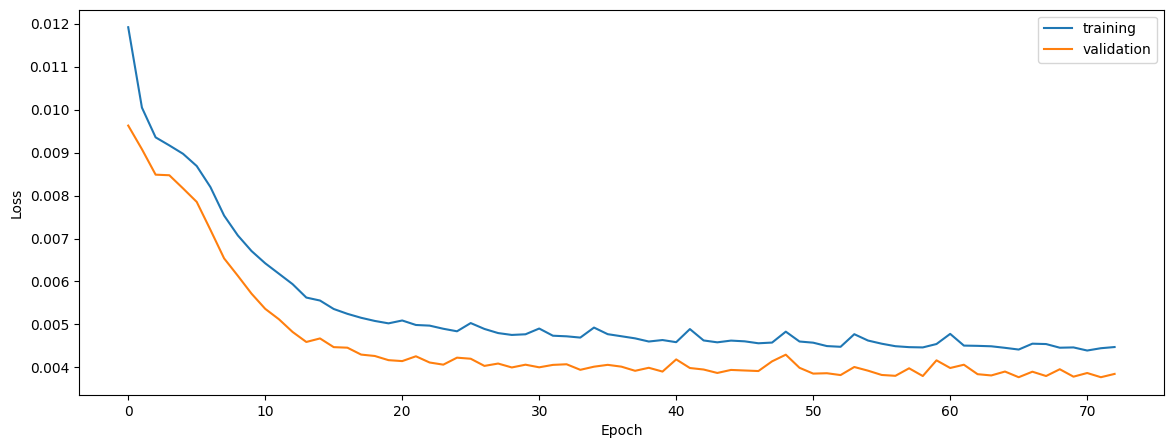

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


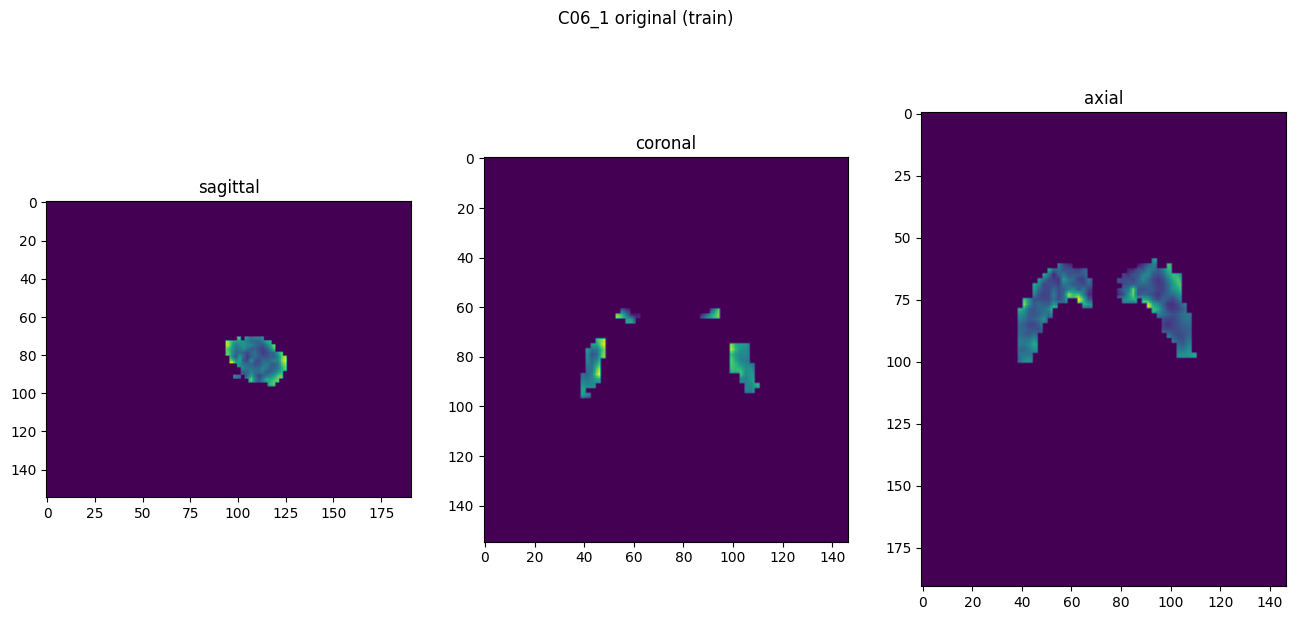

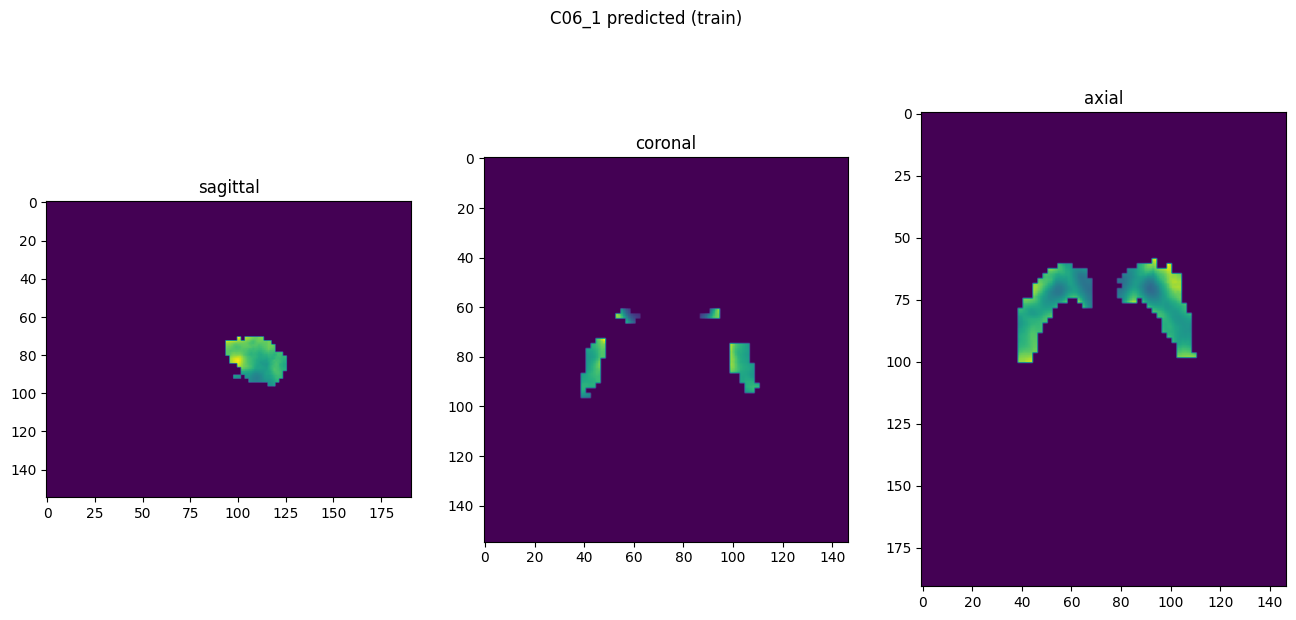

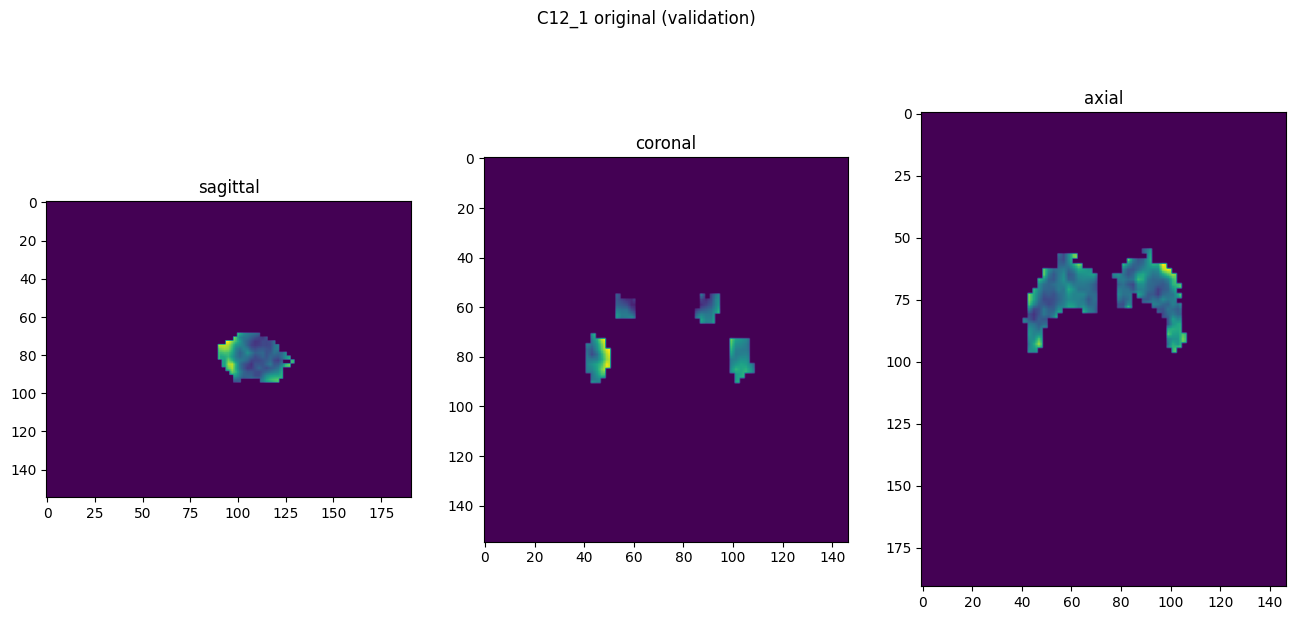

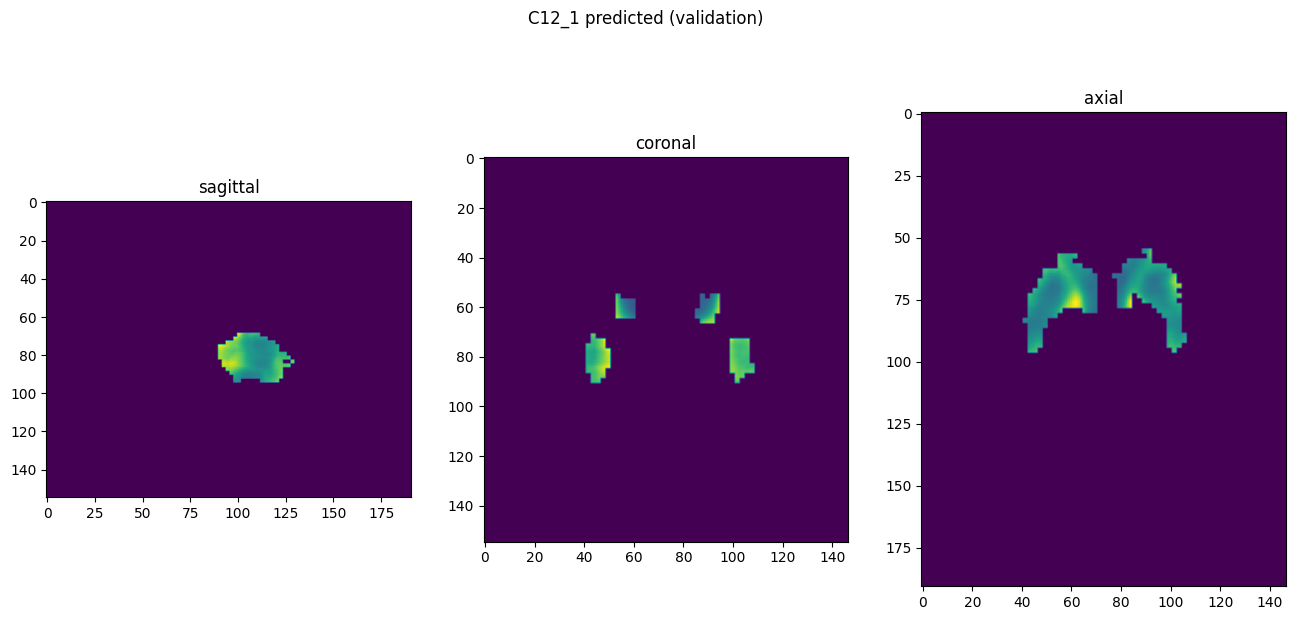

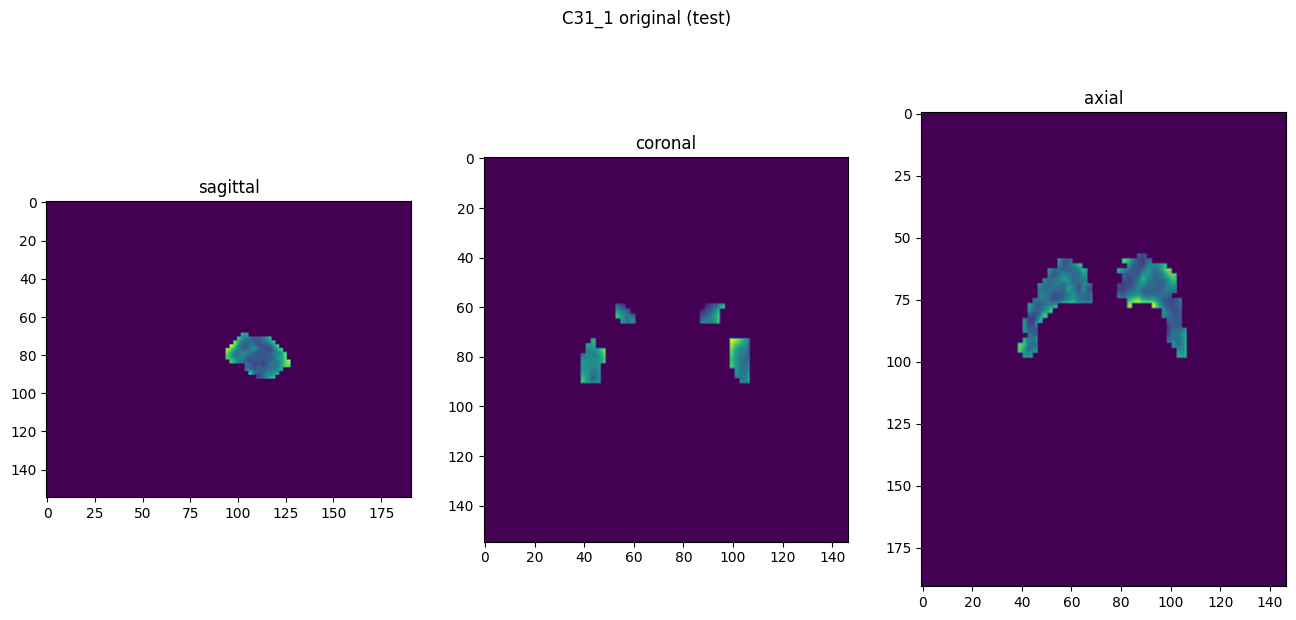

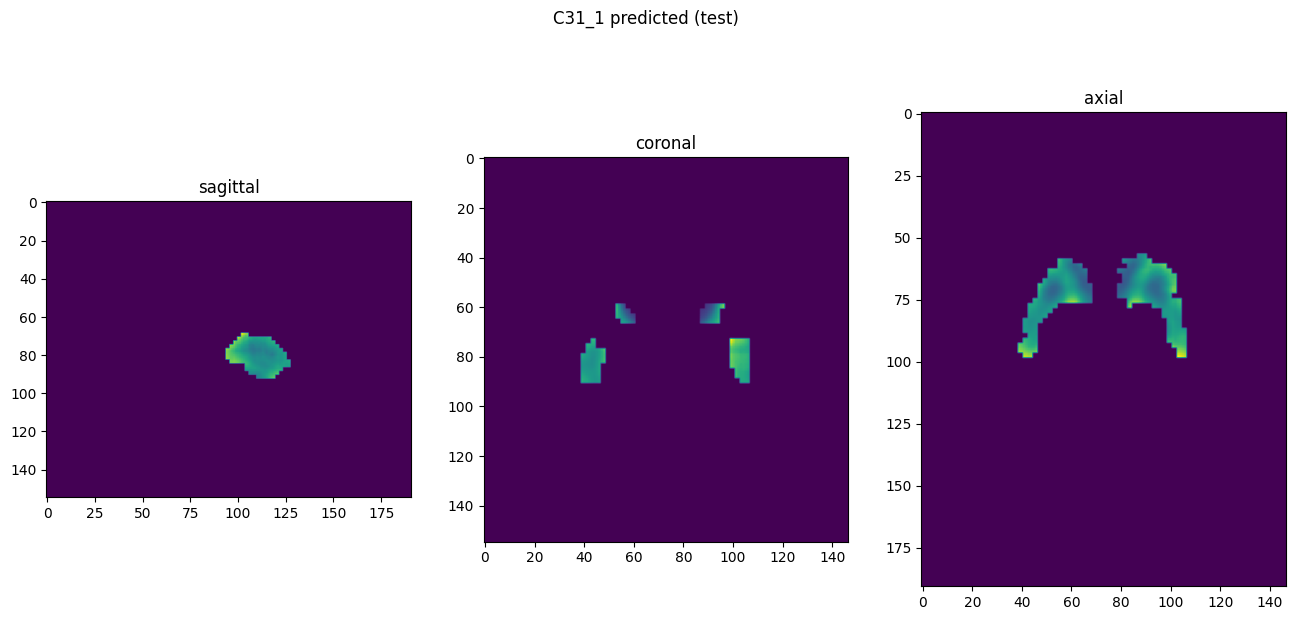

In [10]:
showResults(model, gen, threshold=None, background=False)